# Time series prediction with LSTM

This notebooks aims to predict future stock price using Deep Learning, in particular, LSTM model, using Tensorflow 2.0.

Here, I used not only historical prices, but other information such as Open, Close, High, Low and exchange Volume. Percentage change is used instead of absolute value.

**Results**
* Using LSTM to predict stock data seems like a bad idea. The models hardly converge and the results don't make much sense
* Possible reasons for low performance: 
(1) Deep learning model is data hungry. In this case, we only have a few thoundsands data point, surely not enough. (2) The price change, looks to me to be quite random. So, the model did not learn the fluctuation, but instead the trend that general the market goes up.

**Credits**: I learned how to use LSTM for time-series prediction from [here](https://www.tensorflow.org/tutorials/structured_data/time_series)

## Import data and libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import tensorflow as tf

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Library for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rcParams
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize':18
    
}
rcParams.update(params)
rcParams['figure.figsize'] = 10,5
rcParams['figure.dpi'] = 100

from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

In [3]:
asset = "^GSPC"
df_orig = wb.DataReader('^GSPC', data_source='yahoo', start='1995-1-1')
df_orig.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

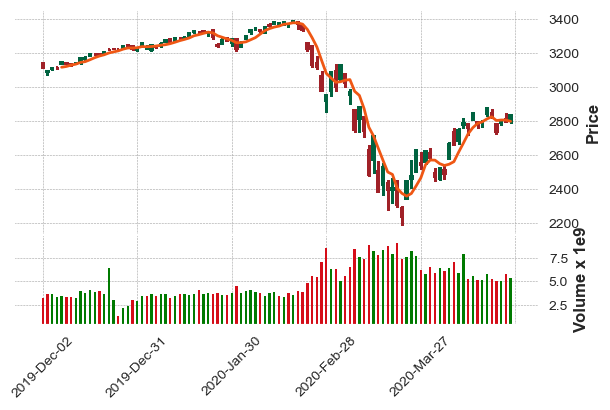

In [4]:
df_plt = df_orig[-100:]
kwargs = dict(type='candle',mav=(5),volume=True,figratio=(10,6),figscale=0.75)
mpf.plot(df_plt,**kwargs,style='charles')


# Data processing

In [171]:
df = df_orig.copy()
df['stick_height'] = (df['High'] - df['Low'])/df['Adj Close']*100
df['open_gap'] = (df['Open'] - df['Close'].shift(1))/df['Adj Close']*100
df['upper_stick'] = (df['High']-df[['Open','Close']].max(axis=1))/df['Adj Close']*100
df['lower_stick'] = (df[['Open','Close']].min(axis=1)-df['Low'])/df['Adj Close']*100
df['volume_change'] = df['Volume'].diff(1)/df['Volume'].shift(1)*100
df['price_change'] = df['Adj Close'].diff(1)/df['Adj Close'].shift(1)*100
df = df[1:]

In [172]:
train_cols = ['stick_height','open_gap','upper_stick','lower_stick','price_change']
df[train_cols] = df[train_cols].clip(lower=-50,upper=50)

# Tensorflow model
## Constants

In [173]:
tf.random.set_seed(13)
TRAIN_SPLIT = int(len(df)*0.9)
HIST_WINDOW = 250
FUTURE_WINDOW = 25
STEP = 2
BUFFER_SIZE = 10000
BATCH_SIZE = 128

EPOCHS = 10


## Prepare data

In [174]:
df_train = df
train_mean = df_train[:TRAIN_SPLIT].mean()
train_std = df_train[:TRAIN_SPLIT].std()

In [175]:
df_train

,High,Low,Open,Close,Volume,Adj Close,stick_height,open_gap,upper_stick,lower_stick,volume_change,price_change
Date,,,,,,,,,,,,
1995-01-04,460.720001,457.559998,459.130005,460.709991,319510000,460.709991,0.685899,0.004345,0.002173,0.340780,21.741284,0.348502
1995-01-05,461.299988,459.750000,460.730011,460.339996,309050000,460.339996,0.336705,0.004349,0.123816,0.128165,-3.273763,-0.080310
1995-01-06,462.489990,459.470001,460.380005,460.679993,308070000,460.679993,0.655550,0.008685,0.392897,0.197535,-0.317101,0.073858
1995-01-09,461.769989,459.739990,460.670013,460.829987,278790000,460.829987,0.440509,-0.002165,0.203980,0.201815,-9.504333,0.032559
1995-01-10,464.589996,460.899994,460.899994,461.679993,352450000,461.679993,0.799255,0.015164,0.630308,0.000000,26.421321,0.184451
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,2868.979980,2820.429932,2845.620117,2823.159912,5220160000,2823.159912,1.719706,-1.025090,0.827437,0.096699,-9.875107,-1.788105
2020-04-21,2785.540039,2727.100098,2784.810059,2736.560059,5075830000,2736.560059,2.135526,-1.401389,0.026675,0.345688,-2.764858,-3.067480
2020-04-22,2815.100098,2775.949951,2787.889893,2799.310059,5049660000,2799.310059,1.398564,1.833660,0.564069,0.426532,-0.515581,2.293025


In [176]:
#df_train = (df_train-train_mean)/train_std
df_train.head()

,High,Low,Open,Close,Volume,Adj Close,stick_height,open_gap,upper_stick,lower_stick,volume_change,price_change
Date,,,,,,,,,,,,
1995-01-04,460.720001,457.559998,459.130005,460.709991,319510000,460.709991,0.685899,0.004345,0.002173,0.340780,21.741284,0.348502
1995-01-05,461.299988,459.750000,460.730011,460.339996,309050000,460.339996,0.336705,0.004349,0.123816,0.128165,-3.273763,-0.080310
1995-01-06,462.489990,459.470001,460.380005,460.679993,308070000,460.679993,0.655550,0.008685,0.392897,0.197535,-0.317101,0.073858
1995-01-09,461.769989,459.739990,460.670013,460.829987,278790000,460.829987,0.440509,-0.002165,0.203980,0.201815,-9.504333,0.032559
1995-01-10,464.589996,460.899994,460.899994,461.679993,352450000,461.679993,0.799255,0.015164,0.630308,0.000000,26.421321,0.184451


In [177]:
len(df_train)

6372

In [178]:
def prepare_train_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, step):
        indices = range(i-history_size, i)
        data.append(dataset.iloc[indices].values)
        labels.append(target.iloc[i:i+target_size].values)

    return np.array(data), np.array(labels)

In [179]:
X_train, Y_train = prepare_train_data(df_train[train_cols], df_train['price_change'], 0, TRAIN_SPLIT, HIST_WINDOW, FUTURE_WINDOW, STEP)
X_val, Y_val = prepare_train_data(df_train[train_cols], df_train['price_change'], TRAIN_SPLIT, None, HIST_WINDOW, FUTURE_WINDOW, STEP)

In [180]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [181]:
train_data

<RepeatDataset shapes: ((None, 250, 5), (None, 25)), types: (tf.float64, tf.float64)>

## Model

In [182]:
def time_series_model(name='time_series_model'):
    inputs = tf.keras.Input(shape=(HIST_WINDOW,5),name='inputs')
    x = tf.keras.layers.LSTM(32,
                             input_shape=X_train.shape[-2:],
                            name='lstm_1')(inputs)
    x = tf.keras.layers.Dense(32, activation='relu', name='dense')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout')(x)
    outputs = tf.keras.layers.Dense(FUTURE_WINDOW, activation=None, name='output')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [183]:
model = time_series_model()

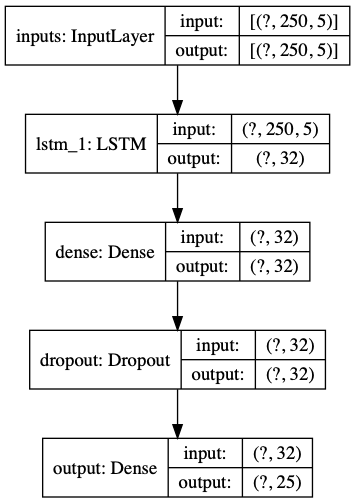

In [184]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [185]:
model.summary()

Model: "time_series_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 250, 5)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 25)                825       
Total params: 6,745
Trainable params: 6,745
Non-trainable params: 0
_________________________________________________________________


In [192]:
#optimizer = tf.keras.optimizers.RMSprop(clipvalue=5.0)
optimizer = tf.keras.optimizers.Adam(lr=1.0)
model.compile(optimizer=optimizer, loss='mae')

In [193]:
int(len(X_train)/BATCH_SIZE)

21

In [194]:
hist = model.fit(train_data,
                epochs=EPOCHS,
                 steps_per_epoch=int(len(X_train)/BATCH_SIZE),
                validation_data=val_data,
                validation_steps=50)

Train for 21 steps, validate for 50 steps
Epoch 1/10
21/21 [==============================] - 5s 233ms/step - loss: 4.7126 - val_loss: 1.1849
Epoch 2/10
21/21 [==============================] - 3s 135ms/step - loss: 0.8459 - val_loss: 1.1278
Epoch 3/10
21/21 [==============================] - 3s 135ms/step - loss: 0.8086 - val_loss: 1.1269
Epoch 4/10
21/21 [==============================] - 3s 137ms/step - loss: 0.8225 - val_loss: 1.1252
Epoch 5/10
21/21 [==============================] - 3s 134ms/step - loss: 0.8156 - val_loss: 1.1224
Epoch 6/10
21/21 [==============================] - 3s 138ms/step - loss: 0.8151 - val_loss: 1.1247
Epoch 7/10
21/21 [==============================] - 3s 137ms/step - loss: 0.8154 - val_loss: 1.1257
Epoch 8/10
21/21 [==============================] - 3s 136ms/step - loss: 0.8238 - val_loss: 1.1265
Epoch 9/10
21/21 [==============================] - 3s 135ms/step - loss: 0.8207 - val_loss: 1.1293
Epoch 10/10
21/21 [==============================] - 3s 13

## Visualize results

In [195]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

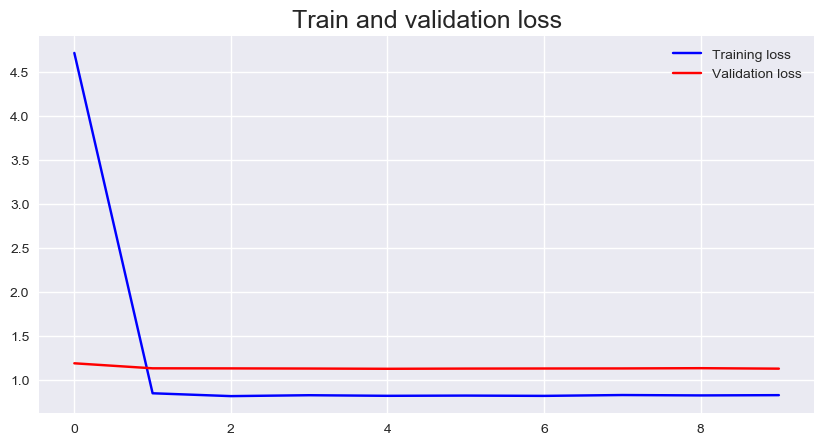

In [196]:
plot_train_history(hist, 'Train and validation loss')

In [208]:
def make_prediction(df_input, model):
    tmp_df = df_input.copy()[-HIST_WINDOW:]
    x_pred = tmp_df.values
    y_pred = model.predict(x_pred.reshape(-1,HIST_WINDOW,5))
    return y_pred

In [213]:
def plot_time(y_train, y_pred, start_date=None, y_val=None):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    x_train = np.arange(-len(y_train),0,1)
    x_pred = np.arange(1,len(y_pred)+1,1)
    plt.plot(x_train, y_train, color='black', linewidth=1.5, label='Historical price')
    plt.plot(x_pred, y_pred, color='red',label='Prediction',alpha=0.8)
    try:
        x_val = np.arange(1,len(y_val)+1,1)
        plt.plot(x_val, y_val, color='blue',label='Val',alpha=0.6)
    except:
        pass
    plt.xlabel('Days')
    plt.ylabel('Price')
    fig.canvas.draw()
    
    # Label start date
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    if start_date != None:
        for i in range(len(labels)):
            if labels[i] == '0':
                labels[i] = start_date
    ax.set_xticklabels(labels)
    plt.legend(loc='best')

In [214]:
y_change_pred = make_prediction(df_train[:-FUTURE_WINDOW][train_cols], model).reshape(-1,1)/100
y_val = df_train[-FUTURE_WINDOW:]['price_change']/100

Text(74.47222222222221, 0.5, 'Price change')

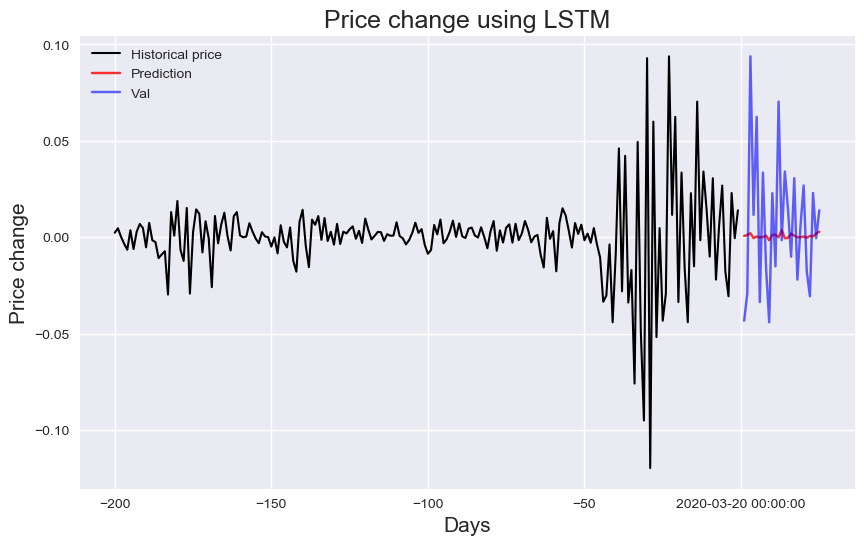

In [215]:
y_train = df_train[-200:]['price_change']/100
start_date = df_train.index[-FUTURE_WINDOW]
plot_time(y_train, y_change_pred, start_date, y_val)
plt.title("Price change using LSTM")
plt.ylabel('Price change')

In [216]:
def make_forward_pred(y_start, change_rate):
    outlist = []
    y_last = y_start
    for rate in change_rate:
        y_cur = y_last*(1+rate)
        outlist.append(y_cur)
        y_last = y_cur
    return outlist

Text(0.5, 1, 'Price pred using LSTM')

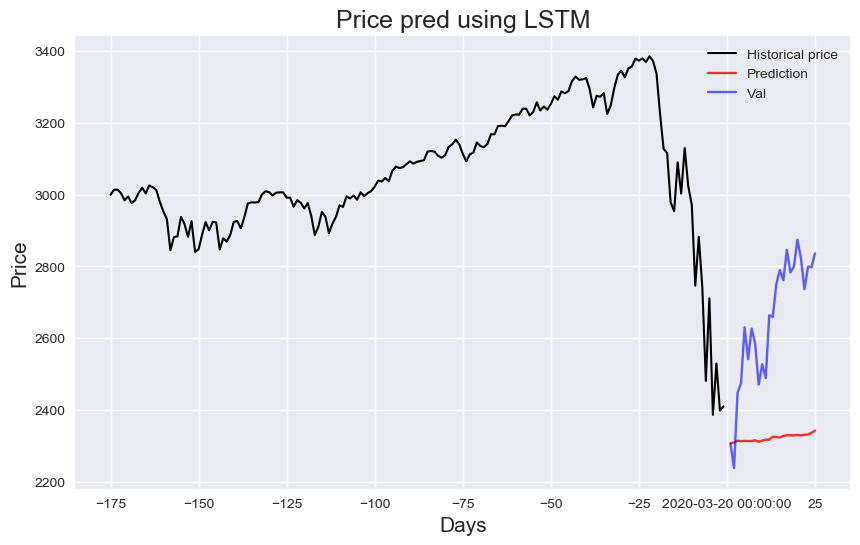

In [217]:
y_pred = make_forward_pred(df_train['Adj Close'].values[-FUTURE_WINDOW], y_change_pred)
y_train = df_train[-200:-FUTURE_WINDOW]['Adj Close']
start_date = df_train.index[-FUTURE_WINDOW]
y_val = df_train[-FUTURE_WINDOW:]['Adj Close']
plot_time(y_train, y_pred, start_date, y_val)
plt.title("Price pred using LSTM")

## Future prediction

Text(0.5, 1, 'Price pred using LSTM')

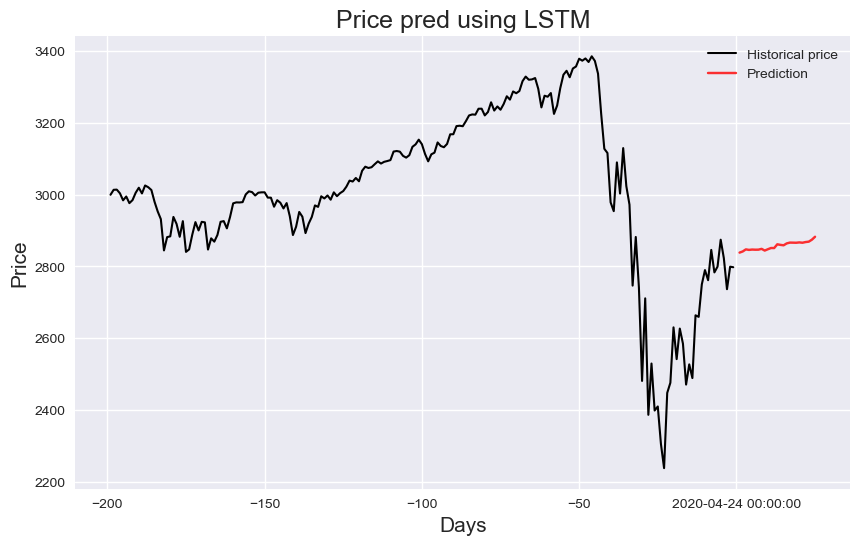

In [218]:
y_change_pred = make_prediction(df_train[train_cols], model).reshape(-1,1)/100
y_pred = make_forward_pred(df_train['Adj Close'].values[-1], y_change_pred)
y_train = df_train[-200:-1]['Adj Close']
start_date = df_train.index[-1]
plot_time(y_train, y_pred, start_date,None)
plt.title("Price pred using LSTM")